# Modelling and Evaluation Notebook

## Objectives

* Answer business requirement 2
* * The client is interested to tell whether a given cell contains a malaria parasite or not.

## Inputs

* input/Apple_vs_Orange/test/Apple
* input/Apple_vs_Orange/test/Orange
* input/Apple_vs_Orange/train/Apple
* input/Apple_vs_Orange/train/Orange
* input/Apple_vs_Orange/validation/Apple
* input/Apple_vs_Orange/validation/Orange

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments | Insights | Conclusions

---

# Import regular packages

In [1]:
%pip install -r /workspace/CI_PP5_Apples/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set working directory

In [3]:
cwd = os.getcwd()

In [4]:
os.chdir('/workspace/CI_PP5_Apples')
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/workspace/CI_PP5_Apples'

---

# Set input directory

Set train, test, and validation paths

In [6]:
my_data_dir = 'input/Apple_vs_Orange/'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

# Set output directory

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


# Set labels

In [8]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['Apple', 'Orange']


# Set image shape

In [9]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(85, 64, 3)

---

# Number of images in train, test and validation data

* train - Apple: 125 images
* train - Orange: 107 images
* validation - Apple: 17 images
* validation - Orange: 15 images
* test - Apple: 37 images
* test - Orange: 31 images




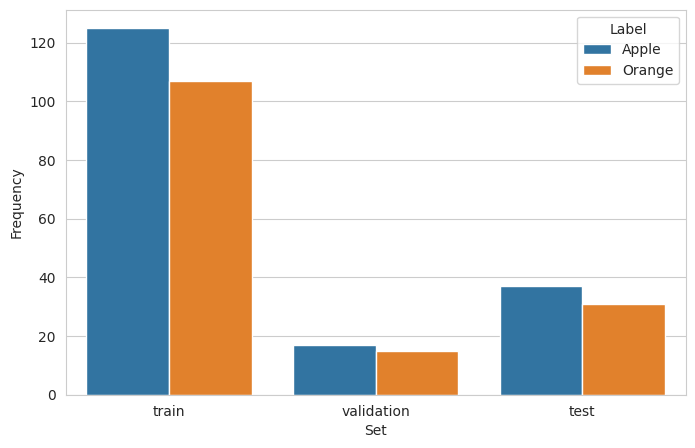

In [10]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

---

## ImageDataGenerator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* # Initialize ImageDataGenerator

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* # Augment training image dataset

In [13]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 232 images belonging to 2 classes.


{'Apple': 0, 'Orange': 1}

* # Augment validation image dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 32 images belonging to 2 classes.


{'Apple': 0, 'Orange': 1}

* # Augment test image dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 68 images belonging to 2 classes.


{'Apple': 0, 'Orange': 1}

# Plot augmented training image

(20, 85, 64, 3)


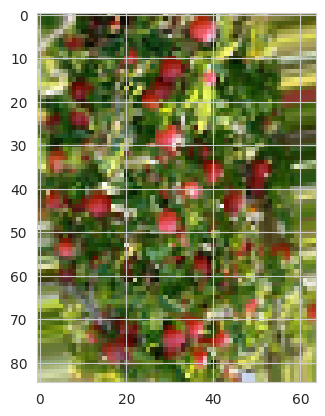

(20, 85, 64, 3)


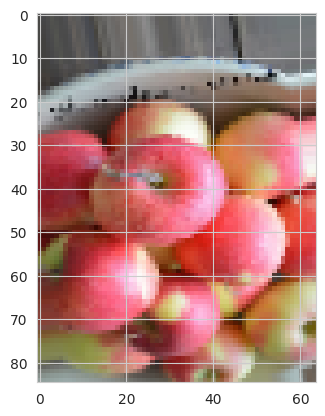

(20, 85, 64, 3)


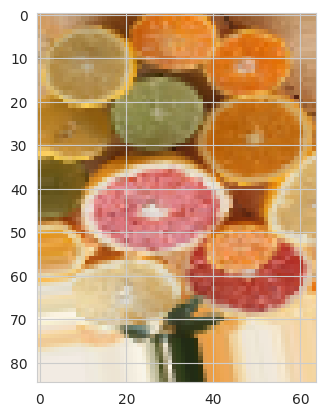

In [16]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

# Plot augmented validation and test images

(20, 85, 64, 3)


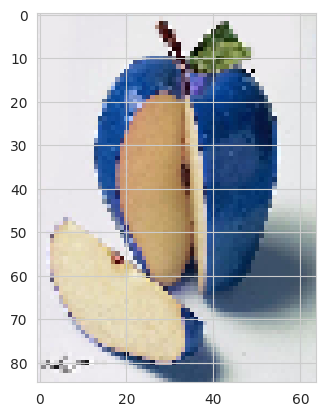

(12, 85, 64, 3)


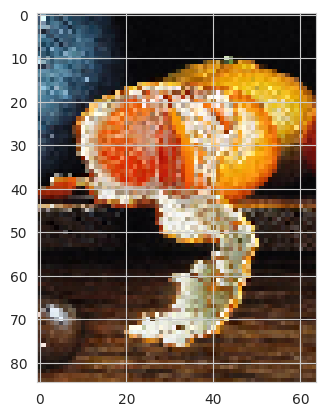

(20, 85, 64, 3)


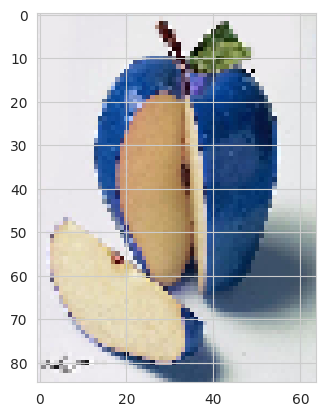

In [17]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 85, 64, 3)


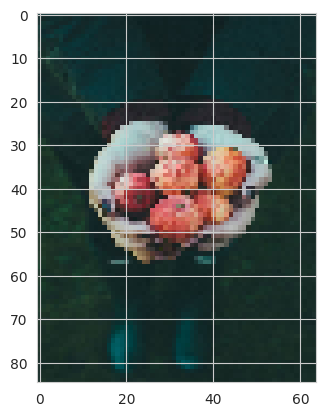

(20, 85, 64, 3)


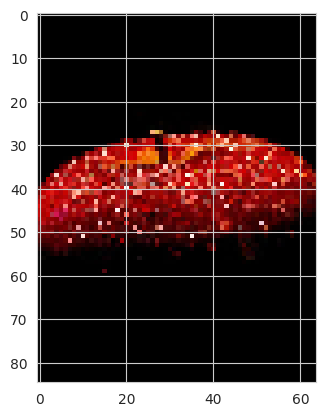

(20, 85, 64, 3)


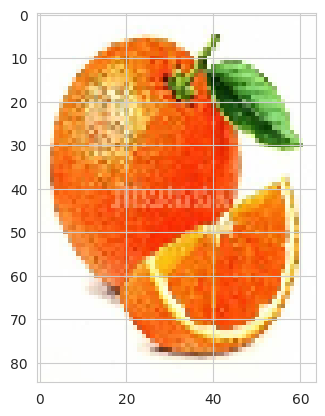

In [18]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

# Save class_indices

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model Creation

---

## ML Model

* ## Import Model Packages

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ## Model

In [21]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

* ## Model Summary

In [22]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 83, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 39, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0

2024-02-15 17:19:11.695137: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* ## Early Stopping

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit model for model training

In [24]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-02-15 17:19:20.013411: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
11/11 [==============================] - 2s 157ms/step - loss: 0.7284 - accuracy: 0.5000 - val_loss: 0.6940 - val_accuracy: 0.5312
Epoch 2/25
11/11 [==============================] - 1s 128ms/step - loss: 0.6894 - accuracy: 0.5660 - val_loss: 0.6928 - val_accuracy: 0.5625
Epoch 3/25
11/11 [==============================] - 2s 141ms/step - loss: 0.6785 - accuracy: 0.5955 - val_loss: 0.6843 - val_accuracy: 0.5625
Epoch 4/25
11/11 [==============================] - 1s 137ms/step - loss: 0.6360 - accuracy: 0.6887 - val_loss: 0.6952 - val_accuracy: 0.6250
Epoch 5/25
11/11 [==============================] - 2s 141ms/step - loss: 0.6245 - accuracy: 0.6604 - val_loss: 0.8229 - val_accuracy: 0.3750
Epoch 6/25
11/11 [==============================] - 1s 128ms/step - loss: 0.6674 - accuracy: 0.5755 - val_loss: 0.6501 - val_accuracy: 0.6562
Epoch 7/25
11/11 [==============================] - 2s 143ms/step - loss: 0.5878 - accuracy: 0.7500 - val_loss: 0.6354 - val_accuracy: 0.6250
Epoch 

## Save model

In [25]:
model.save('outputs/v1/apple_model.h5')

---

# Model Performance

---

## Model learning curve


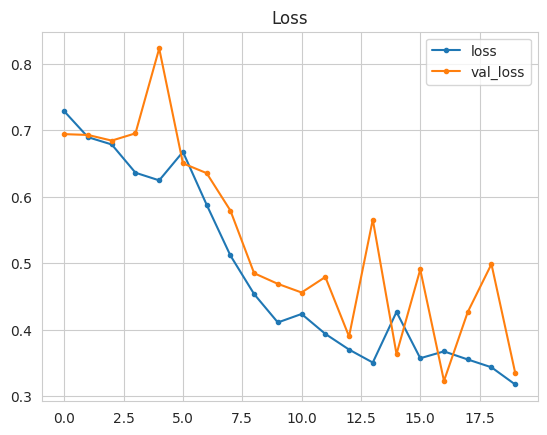

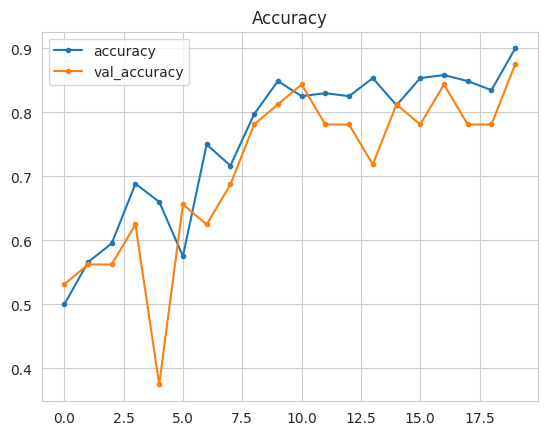

In [26]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model Evaluation

Load saved model

In [27]:
from keras.models import load_model
model = load_model('outputs/v1/apple_model.h5')

Evaluate model on test set

In [28]:
evaluation = model.evaluate(test_set)

4/4 [==============================] - 0s 68ms/step - loss: 0.5254 - accuracy: 0.8235


### Save evaluation pickle

In [29]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL

In [30]:
labels[0]

'Apple'

Image shape: (64, 85), Image mode: RGB


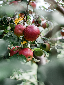

In [31]:
from tensorflow.keras.preprocessing import image

pointer = 33
label = labels[0]  # select Uninfected or Parasitised


pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [32]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 85, 64, 3)


Predict class probabilities

In [33]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.76187863945961
Apple
